# Create main paper results of plot 2 from "Modeling echo chambers and polarization dynamics in social networks"

In [112]:
import matplotlib.pyplot as plt
from society import Society
import numpy as np
import random
%matplotlib inline
plt.style.use('fivethirtyeight')


def eq_1_get_opinion_updates(i, A, X, N, K, α):
    return -X[i] + K * sum([A[i, j] * np.tanh(α * X[j]) for j in range(N) if j != i])


def eq_2_get_peer_interaction_probabilities(X, i, β, N):
    """
    This is equation 2 in the paper.
    """
    # Calculate relative probabilities
    relative_probabilities = [(abs(X[i] - X[j]) ** -β) if j != i else 0 for j in range(N)]
    # Calculate normalization term
    normalization = sum(relative_probabilities)
    # Return normalized probabilities
    return [x / normalization for x in relative_probabilities]


def plot_opinion_histories(times, results):
    plt.figure(figsize=(10, 10))
    for i in range(N):
        signal = np.array(results[i, :])
        pos_signal = signal.copy()
        neg_signal = signal.copy()

        pos_signal[pos_signal <= 0] = np.nan
        neg_signal[neg_signal > 0] = np.nan

        # plotting
        plt.style.use("fivethirtyeight")
        plt.plot(times, pos_signal, color="r", linewidth=1)
        plt.plot(times, neg_signal, color="b", linewidth=1)

        
def run_simulation(α, β):
    # Set all the constants needed for this simulation
    ε = 0.01                          # For activity power law
    γ = 2.1                           # For activity power law
    m = 10                            # Number of distinct other agents to contact if agent is active
    N = 1000                          # Number of agents
    r = 0.5                           # Reciprocity
    K = 3                             # Social interaction strength
    X = np.random.uniform(-1, 1, N)   # Agent's opinions, initialized uniformly between -1 and 1
    t = 0                             # Current simulation time
    T = 10                            # Total simulation time
    dt = 0.01                         # Time step
    Xs = [X]                          # For saving all opinions over time
    α = α                             # Controversialness: tunes the degree of non-linearity between 
                                      # an agent’s opinion and the social influence they exerts on others
    β = β                             # Homophily

    # Draw from power law to get activity values
    activity_values_range = np.linspace(ε, 1, N)
    weights = [((1 - γ) / (1 - ε ** ((1 - γ))) * x ** (-γ)) for x in activity_values_range]
    a = random.choices(activity_values_range, weights=weights, k=N)

    # Run primary algorithm
    times = np.linspace(0, T, round(T / dt))
    results = np.zeros((N, len(times)))
    for t in times:
        # Step 0 - Create temporal adjacency matrix, which will keep track of how each agent influences on another
        A = np.zeros((N, N))
        # Step 1 - Determine which agents are activated for this particular time step
        activated_agents = [i for i in range(N) if random.random() < a[i]]
        # Step 2 - For activated agents...
        for i in activated_agents:
            # ... first get interaction probabilities...
            peer_interaction_probabilities = eq_2_get_peer_interaction_probabilities(X=X, i=i, β=β, N=N)
            # ... then choose m unique agents to interact with...
            interactions = np.random.choice(range(N), size=m, p=peer_interaction_probabilities, replace=False)
            # ... update temporal adjacency matrix...
            for j in interactions:
                A[j, i] = 1
                # ... and finally: Step 3 - account for reciprocity
                if random.random() < r:
                    A[i, j] = 1
        # Step 4 - After applying all interactions of activated agents, numerically integrate and update opinions
        updates = [eq_1_get_opinion_updates(i, A, X, N, K, α) for i in range(N)]
        for i in range(N):
            # Using simple Euler method rather than RK4
            X[i] = X[i] + dt * updates[i]
            results[i, list(times).index(t)] = X[i]
        # Step 5 - Delete A and save current opinions
        del A
    return times, results

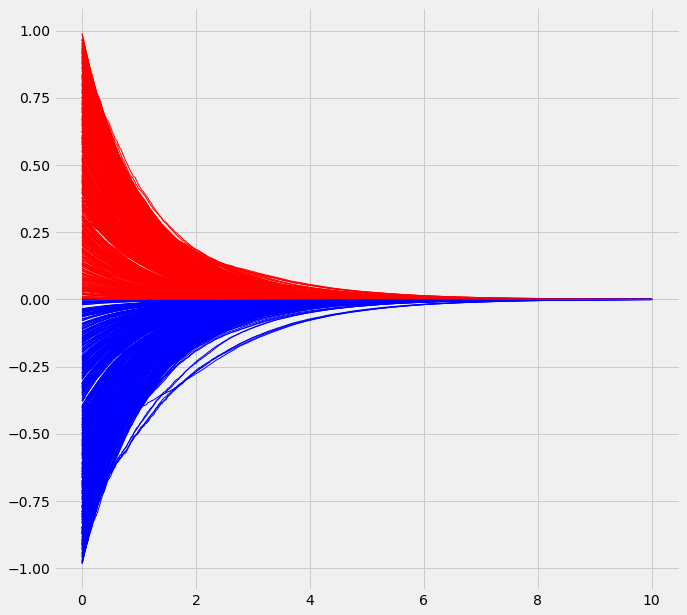

In [113]:
times, results = run_simulation(α=0.05, β=2)
plot_opinion_histories(times, results)

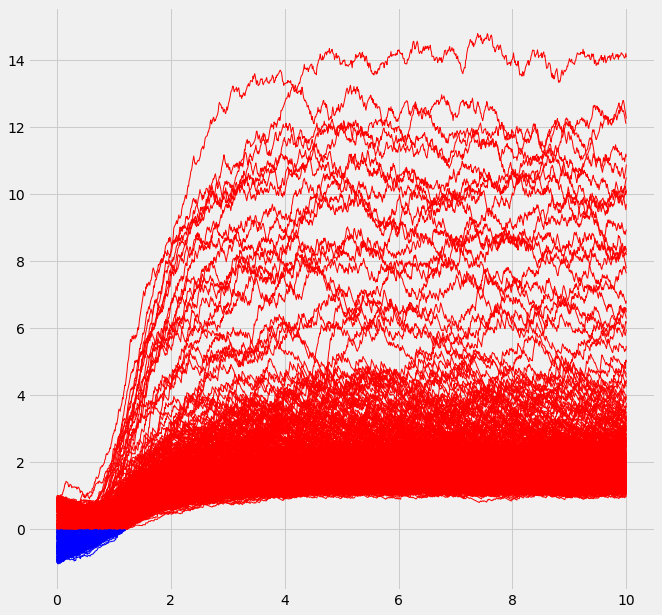

In [114]:
times, results = run_simulation(α=3, β=0)
plot_opinion_histories(times, results)

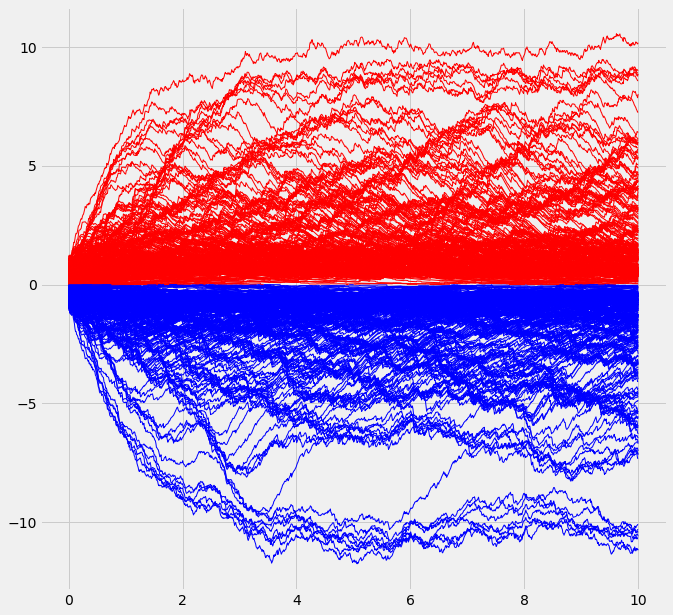

In [115]:
times, results = run_simulation(α=3, β=3)
plot_opinion_histories(times, results)